In [1]:
!pip install pyxdf
!pip install mne
!pip install pandas
!pip install --upgrade jupyterlab ipympl ipywidgets
!pip install scikit-learn
!pip install seaborn


[notice] A new release of pip is available: 24.3.1 -> 25.3
[notice] To update, run: pip install --upgrade pip

[notice] A new release of pip is available: 24.3.1 -> 25.3
[notice] To update, run: pip install --upgrade pip

[notice] A new release of pip is available: 24.3.1 -> 25.3
[notice] To update, run: pip install --upgrade pip

[notice] A new release of pip is available: 24.3.1 -> 25.3
[notice] To update, run: pip install --upgrade pip

[notice] A new release of pip is available: 24.3.1 -> 25.3
[notice] To update, run: pip install --upgrade pip

[notice] A new release of pip is available: 24.3.1 -> 25.3
[notice] To update, run: pip install --upgrade pip


In [2]:
import sys
print(sys.version)

3.9.6 (default, Apr 30 2025, 02:07:17) 
[Clang 17.0.0 (clang-1700.0.13.5)]


In [3]:
import pyxdf
import numpy as np
import mne
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from psychopy_experiments.brand_associations.brands_wordlist import WORDLIST

In [4]:
instagram_wordlist = WORDLIST['instagram']
linkedin_wordlist = WORDLIST['linkedin']
unrelated_wordlist = WORDLIST['unrelated']
CATEGORY_MAP = {item: k for k, v in WORDLIST.items() for item in v}

In [5]:
csv_data = pd.read_csv('data/tika_brand.csv')
# csv_data = pd.read_csv('data/nani_n400.csv')
csv_data

,timestamp_iso,trial_index,brand,target,prime_time_s,target_time_s,resp_window_s,resp_key,rt_ms_from_target
0,2025-11-14T07:28:30.802,0,instagram,დერეფანი,0.16,0.16,1.5,left,1321.87
1,2025-11-14T07:28:33.732,1,instagram,შესაძლებლობა,0.16,0.16,1.5,right,739.44
2,2025-11-14T07:28:36.632,2,instagram,სამსახური,0.16,0.16,1.5,left,894.87
3,2025-11-14T07:28:39.577,3,linkedin,პროფესიონალები,0.16,0.16,1.5,right,992.52
4,2025-11-14T07:28:42.508,4,linkedin,უნარები,0.16,0.16,1.5,right,715.28
...,...,...,...,...,...,...,...,...,...
235,2025-11-14T07:41:29.007,235,instagram,სთორი,0.16,0.16,1.5,left,1030.21
236,2025-11-14T07:41:31.919,236,instagram,გართობა,0.16,0.16,1.5,NaN,NaN
237,2025-11-14T07:41:34.852,237,linkedin,მოგზაურობა,0.16,0.16,1.5,NaN,NaN
238,2025-11-14T07:41:37.783,238,linkedin,წიგნი,0.16,0.16,1.5,right,1014.24


In [6]:
csv_data['category'] = csv_data['target'].map(CATEGORY_MAP).fillna('unknown')

In [7]:
xdf_path = './data/tika_brand.xdf'
xdf_data = pyxdf.load_xdf(xdf_path)[0]
markers = xdf_data[0]
eeg = xdf_data[1]

In [8]:
# Redefine for Luka's data
# xdf_path = './data/luka_n400.xdf'
# xdf_data = pyxdf.load_xdf(xdf_path)[0]
# markers = xdf_data[0]
# eeg = xdf_data[1]

In [9]:
# Read marker data
marker_time = markers['time_stamps']
time_offset = marker_time[0]
marker_time = marker_time - time_offset
marker_data = [x[0] for x in markers['time_series']]

In [10]:
# n400_data = ExperimentData('data/nani_n400.xdf')

In [11]:
CONST_OFFSET = 0.073  # Delay measured with photodiode that day

In [12]:
eeg_time = eeg['time_stamps']
eeg_time = eeg_time - time_offset - CONST_OFFSET
eeg_data = eeg['time_series'][:, :8]

In [13]:
# Create raw data
info = mne.create_info(ch_names=['Fz', 'C3', 'Cz', 'C4', 'Pz', 'PO7', 'Oz', 'PO8'], ch_types=['eeg'] * 8,
                       sfreq=250)
raw = mne.io.RawArray([1e-6 * eeg_data[:, i] for i in range(8)], info)
raw.notch_filter(freqs=[50])
raw.filter(0.5, 30)
raw

Creating RawArray with float64 data, n_channels=8, n_times=242399
    Range : 0 ... 242398 =      0.000 ...   969.592 secs
Ready.
Filtering raw data in 1 contiguous segment
Setting up band-stop filter from 49 - 51 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 49.38
- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 49.12 Hz)
- Upper passband edge: 50.62 Hz
- Upper transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 50.88 Hz)
- Filter length: 1651 samples (6.604 s)

Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.5 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband a

[Parallel(n_jobs=1)]: Done   8 out of   8 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Done   8 out of   8 | elapsed:    0.0s finished


<RawArray | 8 x 242399 (969.6 s), ~14.8 MB, data loaded>

In [14]:
TARGET_MARKER = 1
RESPONSE_MARKER = 2

In [15]:
events = []
for i, marker in enumerate(marker_data):
    eeg_start_index = np.argmax(eeg_time >= marker_time[i]) - 1
    events.append([eeg_start_index, 0, marker])
events = np.array(events)
# NOTE: We remove the last event because it is an artifact (end of recording)
events = events[:-1, :]
events = events[events[:, 2] == 1]

In [16]:
# Define reject criteria
reject_criteria = dict(
    eeg=100e-6,  # 100 µV
)

In [17]:
picks = ["Cz", "Pz"]
event_dict = dict(target=1)
tmin, tmax = -0.2, 1.01
epochs = mne.Epochs(raw.copy(), events, event_id=event_dict, tmin=tmin, tmax=tmax, preload=True,
                    baseline=(None, 0 if tmin < 0 else None), picks=picks, reject=reject_criteria)

Not setting metadata
240 matching events found
Setting baseline interval to [-0.2, 0.0] s
Applying baseline correction (mode: mean)
0 projection items activated
Using data from preloaded Raw for 240 events and 303 original time points ...
    Rejecting  epoch based on EEG : ['Cz']
    Rejecting  epoch based on EEG : ['Cz']
    Rejecting  epoch based on EEG : ['Cz']
    Rejecting  epoch based on EEG : ['Cz']
    Rejecting  epoch based on EEG : ['Cz', 'Pz']
    Rejecting  epoch based on EEG : ['Cz']
    Rejecting  epoch based on EEG : ['Cz']
    Rejecting  epoch based on EEG : ['Cz']
    Rejecting  epoch based on EEG : ['Cz']
    Rejecting  epoch based on EEG : ['Cz', 'Pz']
    Rejecting  epoch based on EEG : ['Cz', 'Pz']
    Rejecting  epoch based on EEG : ['Cz', 'Pz']
    Rejecting  epoch based on EEG : ['Cz']
    Rejecting  epoch based on EEG : ['Cz']
    Rejecting  epoch based on EEG : ['Cz']
    Rejecting  epoch based on EEG : ['Cz', 'Pz']
    Rejecting  epoch based on EEG : ['Cz']


In [18]:
# Get indices for non-rejected epochs
drop_log = epochs.drop_log
drop_log_not_ignored = [log for log in drop_log if 'IGNORED' not in log]
good_epoch_indices = [i for (i, log) in enumerate(drop_log_not_ignored) if len(log) == 0]

In [19]:
# Keep only non-rejected epochs and events from CSV data
csv_data = csv_data.iloc[good_epoch_indices].reset_index(drop=True)
events = events[good_epoch_indices]
csv_data

,timestamp_iso,trial_index,brand,target,prime_time_s,target_time_s,resp_window_s,resp_key,rt_ms_from_target,category
0,2025-11-14T07:28:30.802,0,instagram,დერეფანი,0.16,0.16,1.5,left,1321.87,unrelated
1,2025-11-14T07:28:33.732,1,instagram,შესაძლებლობა,0.16,0.16,1.5,right,739.44,linkedin
2,2025-11-14T07:28:36.632,2,instagram,სამსახური,0.16,0.16,1.5,left,894.87,linkedin
3,2025-11-14T07:28:39.577,3,linkedin,პროფესიონალები,0.16,0.16,1.5,right,992.52,linkedin
4,2025-11-14T07:28:42.508,4,linkedin,უნარები,0.16,0.16,1.5,right,715.28,linkedin
...,...,...,...,...,...,...,...,...,...,...
205,2025-11-14T07:41:29.007,235,instagram,სთორი,0.16,0.16,1.5,left,1030.21,instagram
206,2025-11-14T07:41:31.919,236,instagram,გართობა,0.16,0.16,1.5,NaN,NaN,instagram
207,2025-11-14T07:41:34.852,237,linkedin,მოგზაურობა,0.16,0.16,1.5,NaN,NaN,instagram
208,2025-11-14T07:41:37.783,238,linkedin,წიგნი,0.16,0.16,1.5,right,1014.24,unrelated


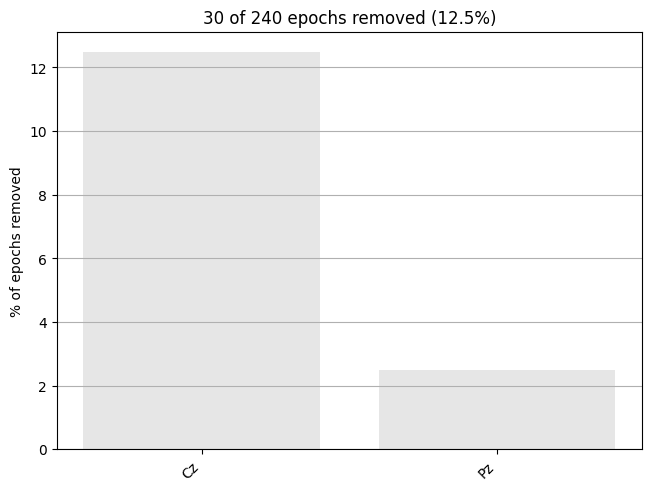

In [20]:
epochs.plot_drop_log(show=True);

In [21]:
# Optional: leave only first unique occurrence of each brand x target pairs
# first_indices = csv_data[['brand', 'target']].drop_duplicates(keep='first').index.values
# # first_indices = csv_data[['brand', 'target']].drop_duplicates(keep='last').index.values
# csv_data = csv_data.iloc[first_indices].reset_index(drop=True)
# epochs = epochs[first_indices]
# events = events[first_indices]

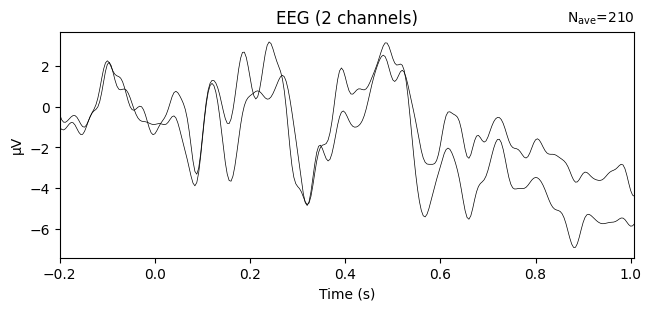

In [22]:
epochs.average().plot(picks=picks)
plt.show()

combining channels using "mean"


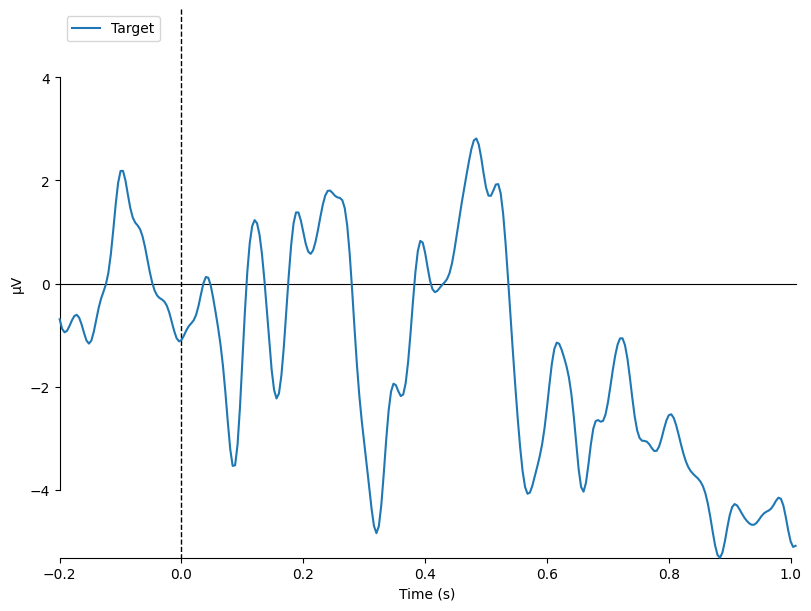

[<Figure size 800x600 with 1 Axes>]

In [23]:
mne.viz.plot_compare_evokeds(
    {"Target": epochs['target'].average()},
    combine='mean',
    show=True
)

In [24]:
instagram_idx = csv_data[csv_data['brand'] == 'instagram'].index.values
linkedin_idx = csv_data[csv_data['brand'] == 'linkedin'].index.values

instagram_words_idx = csv_data[csv_data['target'].isin(instagram_wordlist)].index.values
linkedin_words_idx = csv_data[csv_data['target'].isin(linkedin_wordlist)].index.values
unrelated_words_idx = csv_data[csv_data['target'].isin(unrelated_wordlist)].index.values

response_idx = csv_data[~csv_data['resp_key'].isna()].index.values

# Interesting epochs:
# 1. Everything with response
# 2. For each brand (facebook_idx, youtube_idx):
# 2.1. Facebook words (facebook_words_idx)
# 2.2. Youtube words (youtube_words_idx)
# 2.3. Shared words (shared_words_idx)
# 2.4. Unrelated words (unrelated_words_idx)
filt_ig_idx = np.intersect1d(response_idx, instagram_idx)
filt_li_idx = np.intersect1d(response_idx, linkedin_idx)
ig_ig_words_idx = np.intersect1d(filt_ig_idx, instagram_words_idx)
ig_li_words_idx = np.intersect1d(filt_ig_idx, linkedin_words_idx)
ig_un_words_idx = np.intersect1d(filt_ig_idx, unrelated_words_idx)
li_ig_words_idx = np.intersect1d(filt_li_idx, instagram_words_idx)
li_li_words_idx = np.intersect1d(filt_li_idx, linkedin_words_idx)
li_un_words_idx = np.intersect1d(filt_li_idx, unrelated_words_idx)
ig_instagram = epochs[ig_ig_words_idx]
ig_linkedin = epochs[ig_li_words_idx]
ig_unrelated = epochs[ig_un_words_idx]
li_instagram = epochs[li_ig_words_idx]
li_linkedin = epochs[li_li_words_idx]
li_unrelated = epochs[li_un_words_idx]

In [25]:
unrelated = np.intersect1d(response_idx, unrelated_words_idx)
related = np.union1d(ig_ig_words_idx, li_li_words_idx)

combining channels using "mean"
combining channels using "mean"
combining channels using "mean"


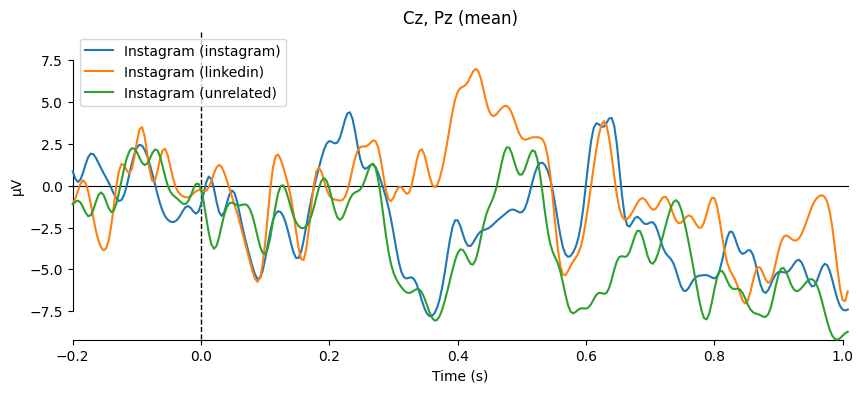

[<Figure size 1000x400 with 1 Axes>]

In [26]:
fig, ax = plt.subplots(figsize=(10, 4))
mne.viz.plot_compare_evokeds(
    {"Instagram (instagram)": ig_instagram.average(), "Instagram (linkedin)": ig_linkedin.average(),
    "Instagram (unrelated)": ig_unrelated.average()},
    picks=picks,
    combine='mean',
    show=True,
    axes=ax
)

combining channels using "mean"
combining channels using "mean"
combining channels using "mean"


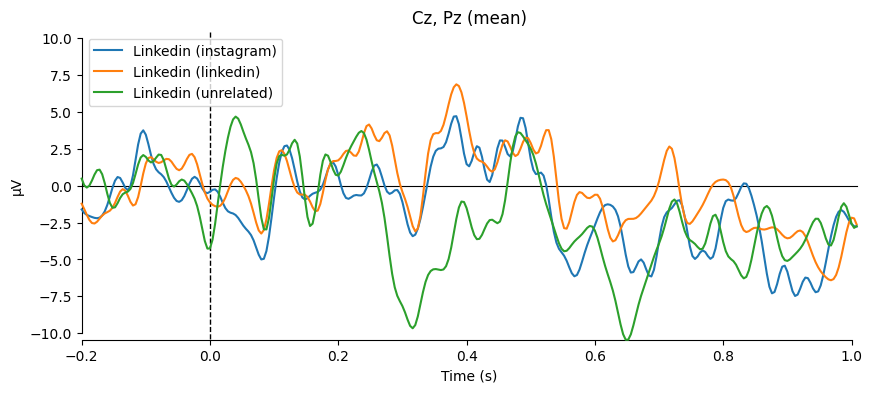

[<Figure size 1000x400 with 1 Axes>]

In [27]:
fig, ax = plt.subplots(figsize=(10, 4))
mne.viz.plot_compare_evokeds(
    {"Linkedin (instagram)": li_instagram.average(), "Linkedin (linkedin)": li_linkedin.average(),
    "Linkedin (unrelated)": li_unrelated.average()},
    picks=picks,
    combine='mean',
    show=True,
    axes=ax
)

## Z-Score Plots

In [57]:
# import numpy as np
# import mne
# from sklearn.preprocessing import StandardScaler

# # --------------------------------------------------------
# # 0. Assume you already have:
# #    - epochs: MNE Epochs, shape (n_trials, n_channels, n_times)
# #    - epochs.metadata["category"] with values like "Television", "Relaxation", "Price", "Unrelated"
# #    - epochs.metadata["subject"] with subject IDs
# # --------------------------------------------------------

# # 1) Select unrelated trials to build the N400 template
# unrel_epochs = epochs[unrelated]
# # if len(unrel_epochs) < 30:
# #     raise ValueError(f"Not enough unrelated trials to build a template. ({len(unrel_epochs)})")

# # 2) Compute the average ERP of unrelated trials
# unrel_evoked = unrel_epochs.average()  # shape (n_channels, n_times)
# data = unrel_evoked.data  # numpy array

In [58]:
# # 3) Define N400 time window (adjust to your data!)
# # typical N400: 300–500 ms
# tmin_n400, tmax_n400 = 0.3, 0.5
# tmask = (unrel_evoked.times >= tmin_n400) & (unrel_evoked.times <= tmax_n400)

# # 4) Build temporal template = average over channels in N400 window
# temporal_template = data.mean(axis=0)[tmask]  # shape (n_times_in_window,)
# # normalize to avoid scaling issues
# temporal_template = temporal_template / np.linalg.norm(temporal_template)

# # 5) Build spatial template = average over time in N400 window
# spatial_template = data[:, tmask].mean(axis=1)  # shape (n_channels,)
# spatial_template = spatial_template / np.linalg.norm(spatial_template)

In [59]:
# # (This gives us separate spatial and temporal “shapes” of the N400)

# # --------------------------------------------------------
# # 6) Now compute a single-trial N400 “score” for every NON-unrelated trial
# #    We'll do a simple separable projection:
# #    score = (spatial dot trial * temporal dot trial_window)
# #    which mimics “how much this trial looks like the N400 template”.
# # --------------------------------------------------------
# # select trials we want to score
# epochs_keep = epochs

# n_trials = len(epochs_keep)
# n400_scores = []

# for ep in epochs_keep:  # ep: (n_channels, n_times)
#     ep_data = ep
#     # project spatially
#     spatial_proj = np.dot(spatial_template, ep_data)  # shape (n_times,)
#     # take N400 window
#     trial_win = spatial_proj[tmask]
#     # project temporally
#     n400_val = np.dot(trial_win, temporal_template)   # scalar
#     n400_scores.append(n400_val)

# n400_scores = np.array(n400_scores)
# n400_scores

In [60]:
# --------------------------------------------------------
# 7) Z-score per subject
# --------------------------------------------------------
# n400_z = np.zeros_like(n400_scores, dtype=float)
n400_scores = y_hat
n400_z = np.zeros_like(y_hat, dtype=float)

# z-score
mean_ = n400_scores.mean()
std_ = n400_scores.std(ddof=1)
if std_ == 0:
    # fallback: no variance
    n400_z = 0.0
else:
    n400_z = (n400_scores - mean_) / std_

print(n400_z)

[ 2.89725982e-01  2.01475103e-01 -2.70030172e-01 -8.92628349e-01
 -1.46419102e-02 -9.23028746e-03 -1.12146959e+00 -8.52936461e-01
  1.46306311e-01 -5.20033826e-01 -1.52663773e+00 -3.83504873e-01
 -1.11136905e+00  1.18895621e-01 -3.38382728e-01 -5.04918403e-01
 -4.52376103e-01 -8.07226863e-02 -1.52345215e-01 -1.34634974e-01
 -7.66987897e-01 -2.40785923e+00 -2.10325938e-01 -2.66184845e-02
 -2.50689523e-01 -1.21357987e+00 -6.15477724e-01  1.55215721e-01
  2.58236677e-01 -1.01007995e+00 -7.01368198e-02 -2.58598533e-01
 -6.93321058e-01 -2.55763620e-01 -2.33422850e-01 -1.73878040e-01
  8.43443390e-02 -5.31433586e-01 -3.27013762e-01  2.44107784e-02
 -1.58919891e+00 -5.04858955e-01 -5.78733930e-01 -2.30827310e-01
 -6.73490217e-01  6.47409059e-02 -4.03477063e-01 -3.61766019e-01
 -4.16124830e-02 -2.39163805e-01  1.46381213e+00 -5.16953396e-01
  1.45856448e+00  1.80461872e+00 -5.74756982e-01  1.45130721e+00
  2.16012739e+00  1.32270652e+00  1.93761194e+00 -6.43115691e-01
  1.47080360e+00 -8.07771

In [65]:
# related_n400_z = n400_scores[:len(related)]
# unrelated_n400_z = n400_scores[len(related):]
unrelated_n400_z = n400_scores[:len(unrelated)]
related_n400_z = n400_scores[len(unrelated):]
print(len(unrelated_n400_z), len(related_n400_z))

64 64


In [66]:
# plt.boxplot([related_n400_z, unrelated_n400_z])
# plt.hist(unrelated_n400_z, bins=20, edgecolor='black')
# plt.title('Related vs Unrelated')
# plt.grid(axis='y', alpha=0.75)
# plt.show()

In [80]:
# csv_data.iloc[related]['score'] = n400_scores
csv_data.loc[unrelated, 'zscore'] = unrelated_n400_z
csv_data.loc[related, 'zscore'] = related_n400_z

In [83]:
# Build a translation table (Unicode codepoint → replacement string)
GE_TO_LAT = {
    ord('ა'): 'a',  ord('ბ'): 'b',   ord('გ'): 'g',   ord('დ'): 'd',
    ord('ე'): 'e',  ord('ვ'): 'v',   ord('ზ'): 'z',   ord('თ'): 't',
    ord('ი'): 'i',  ord('კ'): 'k',   ord('ლ'): 'l',   ord('მ'): 'm',
    ord('ნ'): 'n',  ord('ო'): 'o',   ord('პ'): 'p',   ord('ჟ'): 'zh',
    ord('რ'): 'r',  ord('ს'): 's',   ord('ტ'): "t'",  ord('უ'): 'u',
    ord('ფ'): "p'", ord('ქ'): "k'",  ord('ღ'): 'gh',  ord('ყ'): "q'",
    ord('შ'): 'sh', ord('ჩ'): 'ch',  ord('ც'): 'ts',  ord('ძ'): 'dz',
    ord('წ'): "ts'",ord('ჭ'): "ch'", ord('ხ'): 'kh',  ord('ჯ'): 'j',
    ord('ჰ'): 'h',
}

def georgian_to_latin_series(s: pd.Series) -> pd.Series:
    return s.astype(str).str.translate(GE_TO_LAT)

csv_data['target_latin'] = georgian_to_latin_series(csv_data['target'])
# pdata = csv_data.groupby(['brand', 'category', 'target_latin'])[['score', 'zscore']].mean()
pdata = csv_data.groupby(['brand', 'category', 'target_latin'])[['zscore']].mean()

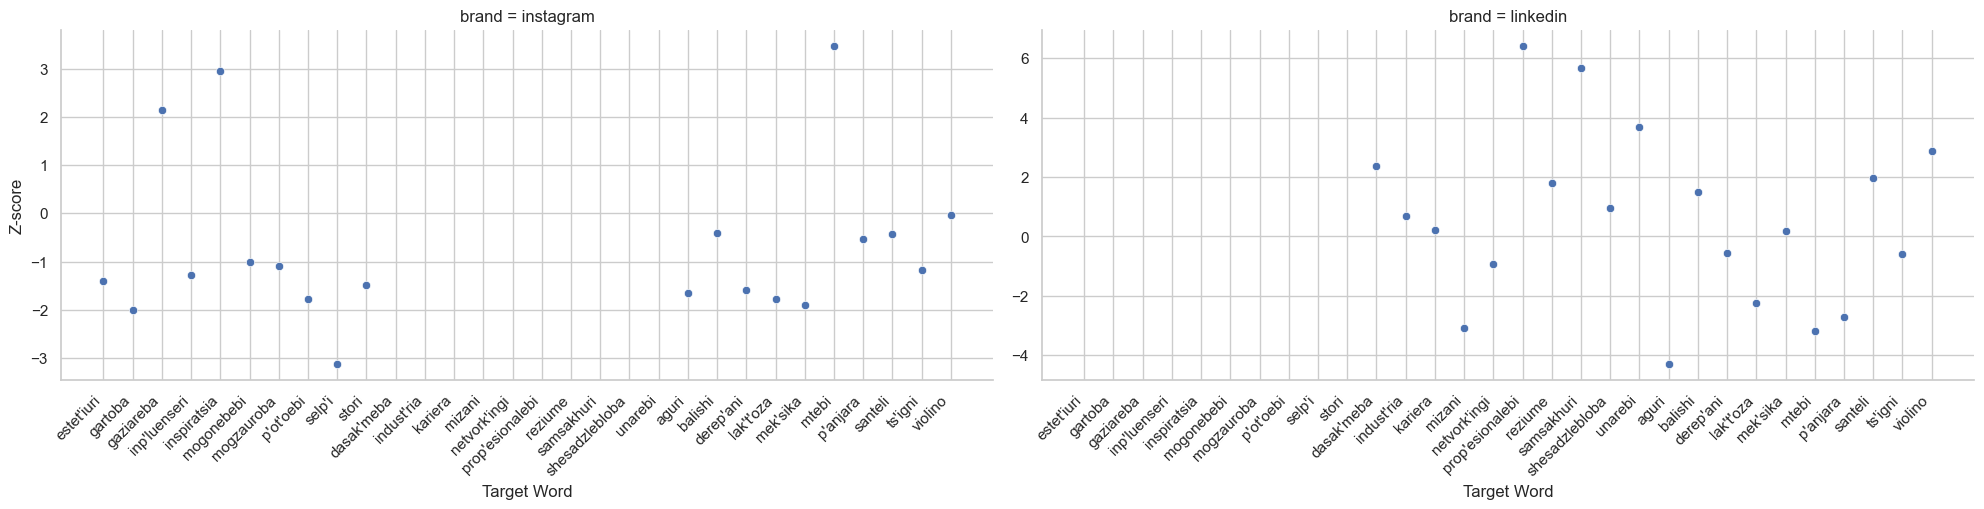

In [84]:
# Assuming pdata was created as described
# Reset index so 'brand' and 'target' become columns
pdata_reset = pdata.reset_index()

# Set plot style
sns.set(style="whitegrid")

# Alternative plot using zscore instead
g = sns.FacetGrid(pdata_reset, col="brand", height=5, sharey=False, aspect=2)
g.map_dataframe(sns.scatterplot, x="target_latin", y="zscore")
g.set_xticklabels(rotation=45, ha='right')
g.set_axis_labels("Target Word", "Z-score")
plt.subplots_adjust(hspace=0.3, bottom=0.25, top=0.95)
# plt.tight_layout()

In [85]:
# import seaborn as sns
# import matplotlib.pyplot as plt

# # Assuming pdata was created as described
# # Reset index so 'brand' and 'target' become columns
# pdata_reset = pdata.reset_index()

# # Set plot style
# sns.set(style="whitegrid")

# # Alternative plot using zscore instead
# g = sns.FacetGrid(pdata_reset, col="brand", height=5, sharey=False, aspect=2)
# g.map_dataframe(sns.scatterplot, x="target_latin", y="zscore")
# g.set_xticklabels(rotation=45, ha='right')
# g.set_axis_labels("Target Word", "Z-score")
# plt.subplots_adjust(hspace=0.3, bottom=0.25, top=0.95)
# # plt.tight_layout()

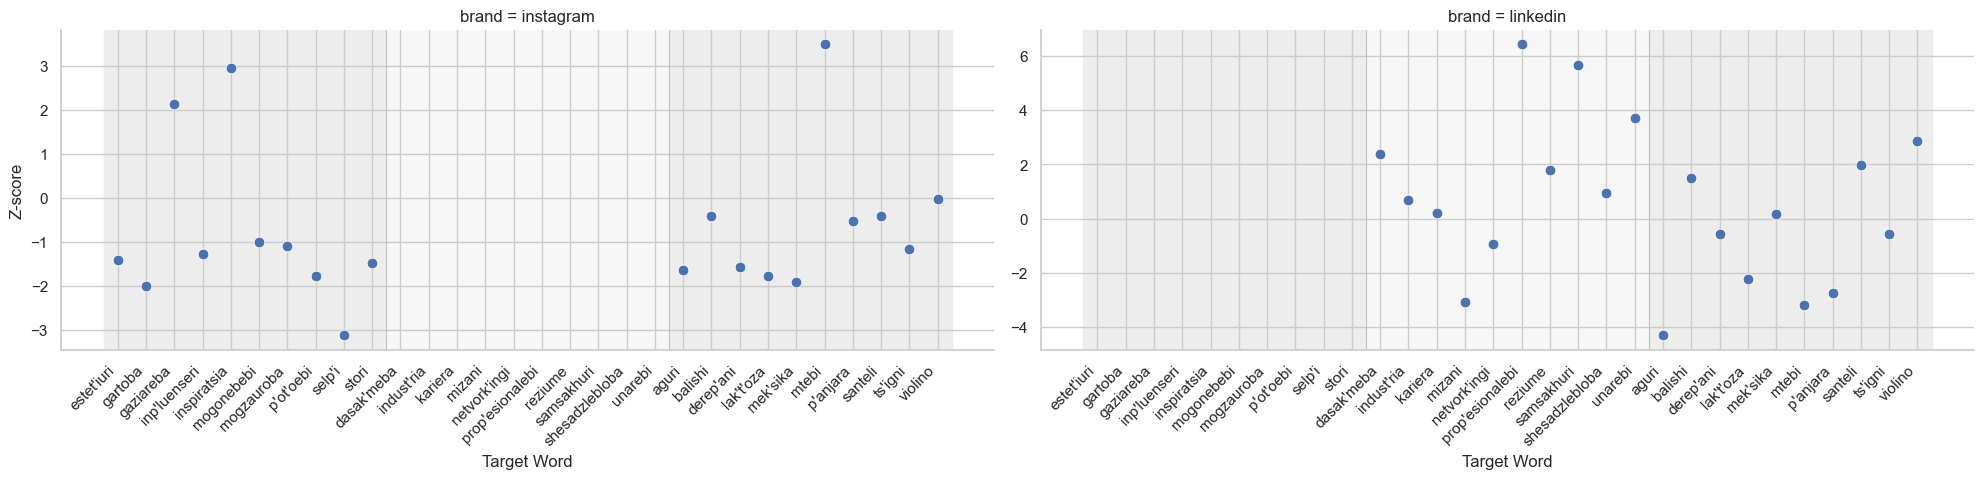

In [86]:
# Order targets by category and add category banding on the x-axis
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

# pdata as in your code; reset for plotting
pdata_reset = pdata.reset_index()

# Category order
CAT_ORDER = ['instagram', 'linkedin', 'unrelated']

# Build target order within categories (alphabetical)
word_order = []
for c in CAT_ORDER:
    w = (pdata_reset.loc[pdata_reset['category'] == c, 'target_latin']
                     .drop_duplicates()
                     .sort_values(key=lambda s: s.str.lower()))
    word_order.extend(w.tolist())

# Encode ordered categories for x
pdata_reset['target_latin'] = pd.Categorical(pdata_reset['target_latin'],
                                             categories=word_order, ordered=True)
x_index = {w: i for i, w in enumerate(word_order)}
pdata_reset['x_pos'] = pdata_reset['target_latin'].map(x_index).astype(int)

# Precompute category intervals (start/end indices on x)
word2cat = dict(pdata_reset[['target_latin', 'category']].drop_duplicates().values)
bounds = []
start = 0
cur = word2cat[word_order[0]]
for i, w in enumerate(word_order):
    c = word2cat[w]
    if c != cur:
        bounds.append((cur, start, i - 1))
        cur, start = c, i
bounds.append((cur, start, len(word_order) - 1))

# Plot
sns.set(style="whitegrid")
g = sns.FacetGrid(pdata_reset, col="brand", height=5, sharey=False, aspect=2)
g.map_dataframe(sns.scatterplot, x="x_pos", y="zscore", s=60)

# Ax cosmetics: ticks, labels, category shading
for ax in g.axes.flat:
    # alternating category bands
    for j, (cat, a, b) in enumerate(bounds):
        ax.axvspan(a - 0.5, b + 0.5, color=str(0.93 + 0.04*(j % 2)), alpha=1.0, zorder=0)
        if j < len(bounds) - 1:
            ax.axvline(b + 0.5, color='0.75', lw=0.8, zorder=1)

    # ticks and ticklabels
    ax.set_xticks(np.arange(len(word_order)))
    ax.set_xticklabels(word_order, rotation=45, ha='right')

g.set_axis_labels("Target Word", "Z-score")
plt.subplots_adjust(hspace=0.35, bottom=0.28, top=0.92, wspace=0.05)
plt.show()

## Beamformer stLCMV

In [87]:
# --- compatibility patch for old-style LinearModel._preprocess_data used by posthoc.Beamformer ---
from sklearn.linear_model._base import LinearModel, _preprocess_data as _skl_preprocess_data

def _preprocess_data_compat(*args, **kwargs):
    # posthoc passes "normalize=...", which no longer exists; just drop it
    kwargs.pop("normalize", None)
    return _skl_preprocess_data(*args, **kwargs)

# attach as a staticmethod so calls like LinearModel._preprocess_data(...) work
LinearModel._preprocess_data = staticmethod(_preprocess_data_compat)
# --- end compatibility patch ---

import numpy as np
from posthoc import Beamformer
from posthoc.cov_estimators import ShrinkageKernel
from sklearn import metrics
from matplotlib import pyplot as plt

In [88]:
event_dict = dict(target=1)
# reject_criteria = dict(
#     eeg=100e-6,
# )
reject_criteria = None
raw_resampled, events_resampled = raw.copy().resample(50, events=events)
epochs = mne.Epochs(raw_resampled, events_resampled, event_dict, tmin=-0.2, tmax=1.01,
                    baseline=(-0.2, 0), preload=True, reject=reject_criteria)
unrel_epochs = epochs[unrelated]
rel_epochs = epochs[related]
merged_epochs = mne.concatenate_epochs([unrel_epochs, rel_epochs])
print(f"Using {len(epochs)} epochs for beamformer template.")

Not setting metadata
210 matching events found
Applying baseline correction (mode: mean)
0 projection items activated
Using data from preloaded Raw for 210 events and 61 original time points ...
0 bad epochs dropped
Not setting metadata
128 matching events found
Applying baseline correction (mode: mean)
Using 210 epochs for beamformer template.


In [89]:
unrelated, related

(array([  0,   7,   8,  13,  14,  18,  21,  25,  26,  30,  31,  33,  34,
         38,  39,  40,  42,  46,  52,  56,  57,  59,  63,  66,  72,  81,
         82,  87,  89,  91,  92,  96,  97, 101, 104, 109, 110, 114, 120,
        123, 124, 126, 129, 131, 132, 134, 135, 140, 143, 144, 155, 159,
        162, 166, 169, 170, 174, 177, 179, 183, 187, 199, 202, 208]),
 array([  3,   4,   6,  10,  15,  16,  19,  20,  22,  27,  28,  29,  36,
         41,  47,  48,  55,  58,  62,  65,  68,  69,  70,  71,  73,  75,
         76,  79,  80,  83,  84,  85,  93,  94,  95, 103, 105, 106, 107,
        108, 113, 117, 118, 125, 127, 136, 137, 138, 139, 146, 147, 148,
        149, 150, 153, 156, 157, 163, 168, 171, 178, 181, 190, 205]))

In [90]:
unrel_epochs.get_data().shape, rel_epochs.get_data().shape

((64, 8, 61), (64, 8, 61))

In [91]:
len(unrelated), len(related)

(64, 64)

In [92]:
X = merged_epochs.get_data().reshape(len(merged_epochs), -1)
y = np.array(len(unrel_epochs) * [1] + len(rel_epochs) * [2])
X.shape, y.shape

((128, 488), (128,))

In [93]:
evoked_unrel = X[y == 1].mean(axis=0)
evoked_rel = X[y == 2].mean(axis=0)
template = evoked_rel - evoked_unrel

Text(0.5, 1.0, 'Original template')

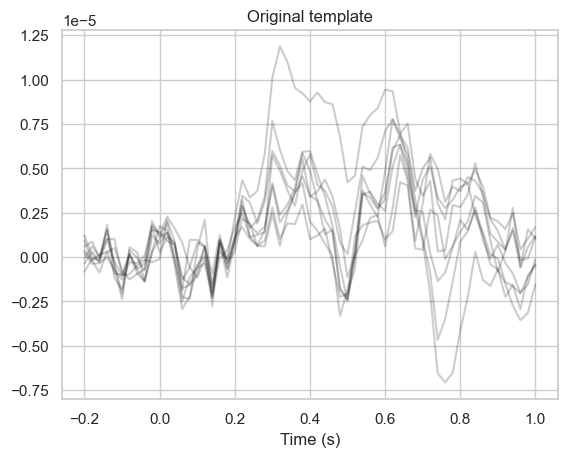

In [94]:
# This creates a (channels x time) view of the template
template_ch_time = template.reshape(epochs.info['nchan'], -1)
# Plot the template
plt.figure()
plt.plot(epochs.times, template_ch_time.T, color='black', alpha=0.2)
plt.xlabel('Time (s)')
plt.title('Original template')

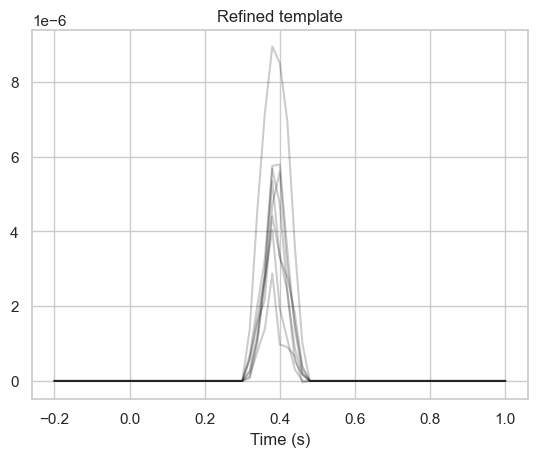

In [95]:
center = np.searchsorted(merged_epochs.times, 0.400)
width = 10
window = np.zeros(len(merged_epochs.times))
window[center - width // 2: center + width // 2] = np.hanning(width)
template_ch_time *= window[np.newaxis, :]
refined_template = template_ch_time.reshape(-1)

# Plot the refined template
plt.figure()
plt.plot(merged_epochs.times, template_ch_time.T, color='black', alpha=0.2)
plt.xlabel('Time (s)')
plt.title('Refined template')
plt.show()

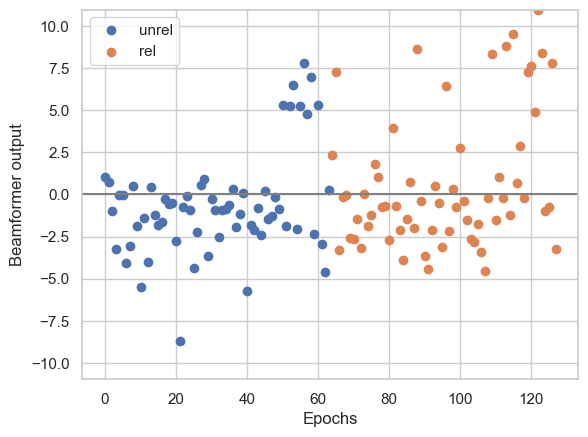

In [96]:
beamformer = Beamformer(refined_template, cov=ShrinkageKernel(1.0)).fit(X)

y_hat = beamformer.predict(X).ravel()

# Visualize the output of the LCMV beamformer
y_unrel = y_hat[y == 1]
y_rel = y_hat[y == 2]
lim = np.max(np.abs(y_hat))
plt.figure()
plt.scatter(np.arange(len(y_unrel)), y_unrel)
plt.scatter(np.arange(len(y_unrel), len(y_unrel) + len(y_rel)), y_rel)
plt.legend(['unrel', 'rel'])
plt.axhline(0, color='gray')
plt.ylim(-lim, lim)
plt.xlabel('Epochs')
plt.ylabel('Beamformer output')

# Assign the 'left' class to values above 0 and 'right' to values below 0
y_bin = np.zeros(len(y_hat), dtype=np.int32)
y_bin[y_hat >= 0] = 1
y_bin[y_hat < 0] = 2